# boundary_conditions_finalize

> Add regularization term to avoid cells collapsing to very small areas, and improve boundary conditions by including two cell rows


In [ ]:
#| default_exp boundary_finalize

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *
from CE_simulation.isogonal import *

In [ ]:
#| export
import os
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize
from scipy import linalg

from tqdm.notebook import tqdm

from copy import deepcopy

from collections import Counter, defaultdict

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial
from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
#config.update("jax_debug_nans", True)  # useful for debugging, but makes code slower!

## Import select functions from other boundary notebook

In [ ]:
from CE_simulation.boundary_jax import get_triangular_lattice, create_rect_mesh, is_bdry, get_centroid,\
                                       get_bdry, get_conformal_transform

## Defining the energy function

In [ ]:
#| export

@patch
def get_primal_energy_fct_jax(self: HalfEdgeMesh, bdry_list=None):
    """Get arrays necessary to compute primal energy from primal vertices. Cell based shape tensor.
    bdry_list: [(penalty function, vertex ids),]
    """

    # book-keeping
    face_keys = sorted(self.faces.keys())
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    n_faces = len(self.faces)
    
    # stuff for boundary energy
    bdry_list = [] if bdry_list is None else bdry_list
    bdry_list = [bdry + [[]] for bdry in bdry_list] #  3rd entry is for the cell ids 
    
    # stuff for the shape tensor energy
    cell_list = []
    rest_shapes = []
    # for future "convenience" also return a vector of _vids corresponding to the cell list
    cell_list_vids = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = jnp.array([face_key_dict[fc._fid] for fc in neighbors])
            cell_list.append(cell)
            cell_list_vids.append(v._vid)
            # check if the cell is in any bdry:
            for bdry in bdry_list:
                if v._vid in bdry[1]:
                    bdry[2].append(len(cell_list)-1)
            
            rest_shapes.append(v.rest_shape)
    valences = [len(cell) for cell in cell_list]
    max_valence = max(valences)
    valence_mask = jnp.array([x*[1,]+(max_valence-x)*[0,] for x in valences])
    # valence mask = (n_cells, max_valence). entry for each cell indicates whether a vertex is a duplicate
    cell_list = jnp.array([jnp.pad(cell, (0, max_valence-len(cell)), mode="edge") for cell in cell_list])
    rest_shapes = jnp.stack(rest_shapes)
    bdry_list = [[bdry[0], jnp.array(bdry[2])] for bdry in bdry_list]

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            # rotate by 90 degrees
            dual_edge = jnp.array([dual_edge[1], -dual_edge[0]])
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]] # 0= he, 1= twin
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = jnp.array(e_dual)
    e_lst_primal = jnp.array(e_lst_primal)        
    
    return (e_lst_primal, e_dual, cell_list, rest_shapes, bdry_list, valence_mask), np.array(cell_list_vids)

In [ ]:
@jit
def polygon_area(pts):
    """area of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return jnp.sum(pts[:,0]*jnp.roll(pts[:,1], 1, axis=0) - jnp.roll(pts[:,0], 1, axis=0)*pts[:,1], axis=0)/2

@jit
def polygon_perimeter(pts):
    """perimeter of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return jnp.sum(jnp.linalg.norm(pts-jnp.roll(pts, 1, axis=0), axis=1), axis=0)


In [ ]:
#| export

@jit
def get_E(x0, e_lst_primal, e_dual, cell_list, rest_shapes, bdry_list, valence_mask,
          mod_bulk=1, mod_shear=.1, angle_penalty=100, bdry_penalty=10, epsilon_l=1e-3):
    n_faces = int(x0.shape[0]/2)
    x, y = (x0[:n_faces], x0[n_faces:])
    pts = jnp.stack([x, y], axis=-1)
    
    # face-based shape energy
    cells = jnp.stack([pts[i] for i in cell_list.T], axis=0)
    edges = cells - jnp.roll(cells, 1, axis=0)
    lengths = jnp.sqrt(jnp.sum(edges**2, axis=-1)+epsilon_l**2)
    # + epsilon**2 to avoid non-differentiable sqrt at 0-length edges (occur due to padding)
    units = (edges.T/lengths.T).T
    tensors = jnp.einsum('efi,efj->fij', edges, units)
    delta = tensors - rest_shapes
    E_shape = jnp.mean(mod_shear*jnp.sum(delta**2, axis=(1,2)) + 
                       mod_bulk*(delta[:,0,0]+delta[:,1,1])**2)

    # angle penalty
    e_primal = pts[e_lst_primal[:,1],:] - pts[e_lst_primal[:,0],:] # he.twin.face-he.face
    lengths = jnp.sqrt(jnp.sum(e_primal**2, axis=-1)+epsilon_l**2)
    # + epsilon to avoid 0-division error and make penalty smooth as length passes through 0
    E_angle = angle_penalty*jnp.mean(1-jnp.einsum('ei,ei->e', e_primal, e_dual)/lengths)
    
    # boundary conditions
    E_bdry = 0
    for bdry in bdry_list:
        centroids = (jnp.sum(cells[:,bdry[1]].T*valence_mask[bdry[1]], axis=-1)
                     /jnp.sum(valence_mask[bdry[1]],axis=-1))
        E_bdry = E_bdry + bdry_penalty*jnp.sum(bdry[0](centroids)) # shape (2, n_cells_in_bdry)
        
    # add area penalty - actually makes things worse!
    #A0 = jnp.sqrt(3)/2
    reg_area = 1
    #E_area = reg_area*jnp.mean((polygon_area(cells)-A0)**4) # no good
    areas = polygon_area(cells)
    E_area = reg_area*jnp.mean((areas-jnp.mean(areas))**2)
    #E_area = reg_area * jnp.mean((delta[:,0,0]+delta[:,1,1])**4) # no good
    
    return E_shape + E_angle + E_bdry + E_area

get_E_jac = jit(jgrad(get_E))
#get_E_jac = jgrad(get_E)

## Example of cell shape optimization with JAX

In [ ]:
# format: penalty function, ids of cells. Need to wrap penalty function in jax.tree_util.Partial.
y_max = 5.5

def up_penalty(x):
    return (x[1]-y_max)**2
def down_penalty(x):
    return (x[1]+y_max)**2

up_penalty = Partial(jit(up_penalty))
down_penalty = Partial(jit(down_penalty))

# trigger compile
_ = up_penalty(np.array([1,1])), down_penalty(np.array([1,1]))

# need to define this once and reuse since it is jitted

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=13, nx=13) # (7,7)

mesh.set_voronoi()
mesh.set_rest_lengths()

for v in mesh.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=0.1))
mesh.transform_vertices(lambda x: shear_mat(1.3)@x+np.random.normal(size=2, scale=0.05)) #0.075

mesh.flip_edge(57)

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False)

plt.gca().set_aspect("equal", adjustable="box");

bdry_up = [up_penalty, [113, 114, 115, 116, 117, 118]] # 117, 118 
bdry_down = [down_penalty, [8, 9, 10, 11, 12, 13]] # 1, -y_max 12, 13
bdry_list = (bdry_up, bdry_down)

In [ ]:
poly = np.round(np.stack([fc.dual_coords for fc in mesh.vertices[113].get_face_neighbors()]), decimals=1)
square = np.array([[0,0],[0,1],[1,1], [1,0]])

plt.scatter(*poly.T, c=np.arange(poly.shape[0]))
#plt.scatter(*poly[2:].T)
#plt.scatter(*square.T)
plt.axis("equal")

(-8.55955268279941, 8.553040005496124, -7.255605436186807, 6.989339281246522)

In [ ]:
polygon_area(poly), sqrt(3)/2

(DeviceArray(0.86, dtype=float64), 0.8660254037844386)

In [ ]:
mod_bulk = 1
mod_shear = .5
angle_penalty = 500
bdry_penalty = 50

epsilon_l = 1e-3

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E_arrays, cell_list_vids = mesh.get_primal_energy_fct_jax(bdry_list)

# create a vector of bulk moduli for active and passive cells

#passive_ids = bdry_up[1]+bdry_down[1] # for example
passive_ids = list(range(104, 111))+list(range(104, 119))+list(range(8, 14))+list(range(16, 23))


act_pass_mask = np.vectorize(lambda x: 1-.9*(x in passive_ids))(cell_list_vids)
mod_bulk_vec = mod_bulk*act_pass_mask
mod_shear_vec = act_pass_mask*mod_shear

cell_shape_args = (mod_bulk_vec, mod_shear_vec, angle_penalty, bdry_penalty, epsilon_l)

In [ ]:
_ = get_E_jac(x0, *(get_E_arrays+cell_shape_args))

get_E(x0, *(get_E_arrays+cell_shape_args))

DeviceArray(867.66411503, dtype=float64)

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                        method="CG", tol=1e-4, options={"maxiter": 1000})

print(sol["message"], "n_eval: ", sol["nfev"], sol["njev"])
print(sol["fun"] , get_E(x0, *(get_E_arrays+cell_shape_args)) / sol["fun"])

# takes: 580ms with BFGS, 30 ms with CG. Hessian-based methods are not really better


# New values for get_E_arrays trigger this

Maximum number of iterations has been exceeded. n_eval:  1715 1715
0.2351085138165943 3690.4836024133456
CPU times: user 384 ms, sys: 32 µs, total: 384 ms
Wall time: 383 ms


In [ ]:
mesh_new = deepcopy(mesh)

new_coord_dict = mesh_new.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh_new.faces.items():
    val.dual_coords = new_coord_dict[key]

In [ ]:
%matplotlib inline

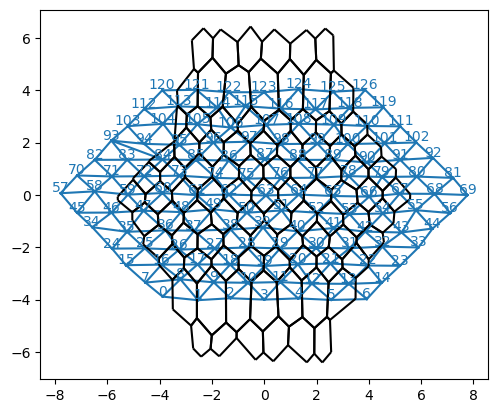

In [ ]:
mesh_new.cellplot()
mesh_new.triplot()
mesh_new.labelplot(face_labels=False)

plt.gca().set_aspect("equal", adjustable="box");


area term with a flipped edge:

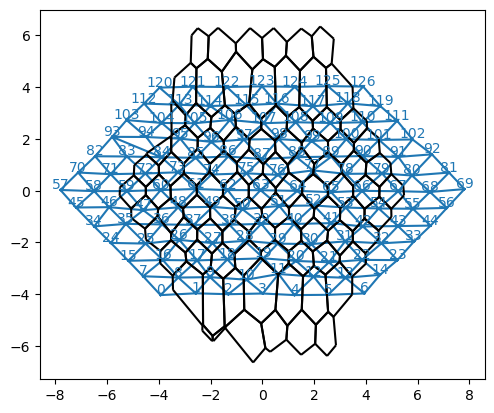

## Timestepping wrappers

Needed to re-write them

To - do: In a refactoring step, put the boundary energy back into notebook 3. Probably want to do everything with JAX from now, need to do rewrite.

In [ ]:
#| export
@patch
def euler_step(self: HalfEdgeMesh, dt=.005, rhs=excitable_dt_post, params=None,
               rhs_rest_shape=None):
    """RHS: callable Ts, Tps -> dTs_dt, dTps_dt. Params can either be a dict of keyword args
    to the RHS function, or a callable faceid -> keyword dict.
    rhs_rest_shape: v -> d_rest_shape_dt, for rest shape dynamics (e.g. viscous relaxation)
    """
    rhs_rest_shape = (lambda v: 0) if rhs_rest_shape is None else rhs_rest_shape
    for fc in self.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        if isinstance(params, dict):
            dT_dt, dTp_dt = rhs(Ts, Tps, **params)
        elif callable(params):
            dT_dt, dTp_dt = rhs(Ts, Tps, **params(fc._fid))
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    for v in self.vertices.values():
        v.rest_shape += dt*rhs_rest_shape(v)


In [ ]:
#| export
@patch
def flatten_triangulation(self: HalfEdgeMesh, tol=1e-3, verbose=True, reg_A=0, A0=sqrt(3)/4):
    """Flatten triangulation"""
    get_E, grd = self.get_energy_fct(reg_A=0, A0=A0)
    x0 = self.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="CG", jac=grd, tol=tol)
    if sol["status"] !=0 and verbose:
        print("Triangulation optimization failed")
        print(sol["message"])
    new_coord_dict = self.initial_cond_to_vertices(sol["x"])
    for key, val in self.vertices.items():
        val.coords = new_coord_dict[key]
    self.set_rest_lengths()


In [ ]:
#| export
@patch
def optimize_cell_shape(self: HalfEdgeMesh, bdry_list=None,
                        energy_args=None, cell_id_to_modulus=None,
                        tol=1e-3, maxiter=500, verbose=True):
    """Primal optimization. cell_id_to_modulus: function from _vid to relative elastic modulus"""
    x0 = mesh.dual_vertices_to_initial_cond()
    get_E_arrays, cell_list_vids = mesh.get_primal_energy_fct_jax(bdry_list)

    if energy_args is None:
        energy_args = {"mod_bulk": 1, "mod_shear": .2,"angle_penalty": 1000, "bdry_penalty": 100,
                       "epsilon_l": 1e-4}
    if cell_id_to_modulus is not None:
        mod_bulk = energy_args["mod_bulk"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
        mod_shear = energy_args["mod_shear"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
    else:
        mod_bulk, mod_shear = (energy_args["mod_bulk"], energy_args["mod_shear"])
    
    cell_shape_args = (mod_bulk, mod_shear, energy_args["angle_penalty"], energy_args["bdry_penalty"],
                       energy_args["epsilon_l"])
    
    sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                             method="CG", tol=tol, options={"maxiter": maxiter})
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.initial_cond_to_dual_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]

In [ ]:
#| export

def excitable_dt_act_pass(Ts, Tps, k=1, m=2, k3=.2):
    """Time derivative of tensions under excitable tension model with constrained area,
    with passive tension for post intercalation. Variant: completely deactivate feedback for m=1.
    k3 is a cutoff in the excitable tension dynamics, for numerical stability at the mesh edges.
    """
    dT_dt = (m-1)*((Ts-Tps)**m - k3*(Ts-Tps)**3 - k*Tps) - k*(m==1) * (Ts-1)
    # use relative tension
    #T_mean = Ts.mean()
    #dT_dt = T_mean *((m-1)*(((Ts-Tps)/T_mean)**m - k3*((Ts-Tps)/T_mean)**3 - k*Tps/T_mean ) )
    
    dTp_dt = -k*Tps
    area_jac = sides_area_jac(Ts-Tps)
    area_jac /= np.linalg.norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)    
    return dT_dt, dTp_dt

## Simulation with boundary conditions and passive & active cells

## To Do

Wrap the code to create a mesh, and set passive regions, as function!

Rename the`mesh.transform_dual_vertices` method - confusing as it refers to primal vertices

## create mesh - hexagonal lattice parallel to strain

In [ ]:
## create mesh

np.random.seed(0)
mesh_initial = create_rect_mesh(7, 15, noise=0.1, defects=(0,0), straight_bdry=True) #0.075 False

center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
mesh_initial.transform_vertices(lambda x: x-center)
mesh_initial.set_centroid()

for v in mesh_initial.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh_initial.transform_vertices(shear_mat(1.15))  #1
mesh_initial.set_rest_lengths()

In [ ]:
## set the boundary conditions and mark the active and passive vertices

passive_ids = []
active_ids = []
bdry_up_ids = []
bdry_down_ids = []

max_y = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
w_passive = 2.5
for fc in mesh_initial.faces.values():
    #if fc.is_bdr():  # make a passive edge - let's see if that is necessary
    #    passive_ids.append(fc._fid)
    if np.abs(fc.dual_coords[1]) > (max_y-w_passive):
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)

# create list of passive cells
passive_cells = [v._vid for v in mesh_initial.vertices.values()
                 if not v.is_bdry() and any([fc._fid in passive_ids for fc in v.get_face_neighbors()])]

max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

w_bdry = .2
for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_up_ids.append(v._vid)
    if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_down_ids.append(v._vid)

In [ ]:
print(max_y_cells)

5.262043969423334


In [ ]:
## create the penalty functions

bdry_y = 5

def up_penalty(x):
    return (x[1]-bdry_y)**2
def down_penalty(x):
    return (x[1]+bdry_y)**2

up_penalty = Partial(jit(up_penalty))
down_penalty = Partial(jit(down_penalty))

bdry_list = ([up_penalty, bdry_up_ids], [down_penalty, bdry_down_ids])

## create mesh - hexagonal orthogonal to strain

Works well looks like!

In [ ]:
## create mesh

np.random.seed(0)
#mesh_initial = create_rect_mesh(12, 9, noise=0.1, defects=(0,0), straight_bdry=True) #0.075 False

mesh_initial = create_rect_mesh(24, 18, noise=0.1, defects=(0,0), straight_bdry=True) #0.075 False


mesh_initial.transform_vertices(rot_mat(pi/2))
center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
mesh_initial.transform_vertices(lambda x: x-center)
mesh_initial.set_centroid()

for v in mesh_initial.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh_initial.transform_vertices(shear_mat(1.15))  #1
mesh_initial.set_rest_lengths()

In [ ]:
## set the boundary conditions and mark the active and passive vertices

passive_ids = []
active_ids = []

max_y = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
w_passive = 6
for fc in mesh_initial.faces.values():
    #if fc.is_bdr():  # make a passive edge - let's see if that is necessary
    #    passive_ids.append(fc._fid)
    if np.abs(fc.dual_coords[1]) > (max_y-w_passive):
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)

# create list of passive cells
passive_cells = [v._vid for v in mesh_initial.vertices.values()
                 if not v.is_bdry() and any([fc._fid in passive_ids for fc in v.get_face_neighbors()])]

max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

w_bdry = .5
shift = .25

bdry_up_ids_row1 = []
bdry_down_ids_row1 = []

for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if ((max_y_cells-shift) > v.get_centroid()[1] > (max_y_cells-shift-w_bdry)) and (not v.is_bdry()):
        bdry_up_ids_row1.append(v._vid)
    if (-(max_y_cells-shift)< v.get_centroid()[1] < -(max_y_cells-shift-w_bdry)) and (not v.is_bdry()):
        bdry_down_ids_row1.append(v._vid)

bdry_up_ids_row0 = []
bdry_down_ids_row0 = []

for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if (v.get_centroid()[1] > (max_y_cells-.1)) and (not v.is_bdry()):
        bdry_up_ids_row0.append(v._vid)
    if (v.get_centroid()[1] < -(max_y_cells-.1)) and (not v.is_bdry()):
        bdry_down_ids_row0.append(v._vid)


In [ ]:
print(max_y_cells)

11.157304114518588


In [ ]:
## create the penalty functions

bdry_y = 11
shift = .5

def up_penalty_row1(x):
    return (x[1]-bdry_y)**2
def down_penalty_row1(x):
    return (x[1]+bdry_y)**2

def up_penalty_row0(x):
    return (x[1]-(bdry_y+shift))**2
def down_penalty_row0(x):
    return (x[1]+(bdry_y+shift))**2

up_penalty_row1 = Partial(jit(up_penalty_row1))
down_penalty_row1 = Partial(jit(down_penalty_row1))

up_penalty_row0 = Partial(jit(up_penalty_row0))
down_penalty_row0 = Partial(jit(down_penalty_row0))


bdry_list = ([up_penalty_row1, bdry_up_ids_row1], [down_penalty_row1, bdry_down_ids_row1],
           #  [up_penalty_row0, bdry_up_ids_row0], [down_penalty_row0, bdry_down_ids_row0]
            )

# not a huge improvement when using both of the boundary conditions. because the distance
# between the boundaries cannot shrink, cells just get very small.

### Plot initial condition

In [ ]:
#| notest
%matplotlib inline

In [ ]:
initial_y_dict = {key: np.round(val.get_centroid()[1], decimals=0) for key, val in mesh_initial.vertices.items()
                  if (not key in passive_cells) and (not val.is_bdry())}

initial_y_dict = {key: val for key, val in initial_y_dict.items()}

print(set(sorted(list(initial_y_dict.values()))))

vmin, vmax = (-5, 5.1)
color_norm = lambda x: ((x-min(initial_y_dict.values())) % 10) / 10
cmap = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=mpl.cm.tab10)  #tab10

alpha = .5
cell_colors = {key: np.array(cmap.to_rgba(color_norm(val)))*np.array([1,1,1,alpha])
               for key, val in initial_y_dict.items()}

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, -1.0, -5.0, -4.0, -3.0, -2.0}


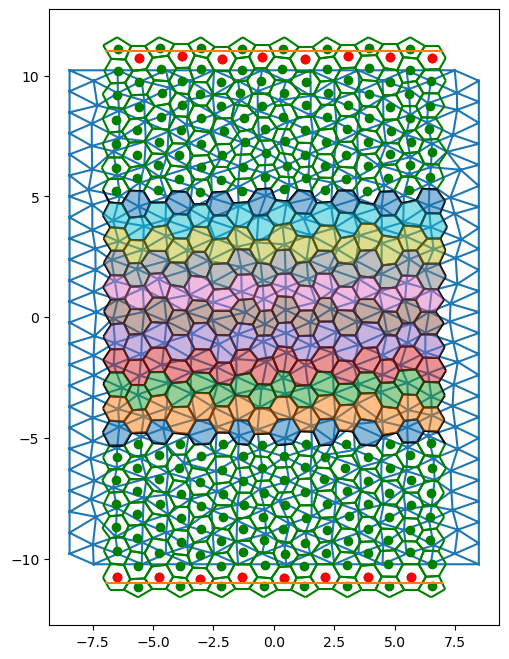

In [ ]:
## plot

passive_edges = flatten([[he._heid for he in mesh_initial.faces[fc].hes] for fc in passive_ids])
edge_colors = {key: "g" for key in passive_edges}

fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
mesh_initial.triplot()

#mesh_initial.labelplot()

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")


for key in passive_cells: # double check passive cells are correctly identified
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="g")

for key in bdry_up_ids_row1+bdry_down_ids_row1:
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="r")
    
plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
## set simulation parameters

# function for active and passive
k = 2
k3 = .4 # .25 regularization term
 
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": k, "m": 1}
    return {"k": k, "m": 2, "k3": k3}

params_no_pattern = {"k": k, "m": 2, "k3": k3}

k_rest = .1 # 2
def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    if v._vid in passive_cells:
        delta = v.rest_shape-v.get_shape_tensor()
        return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    else:
        return 0

dt = .025 # #0.1
n_steps = 60 # 150
forbid_reflip = 40

minimal_l = .075 # .075
tol, maxiter = (1e-4, 20000) # .5*1e-4, 

mod_bulk = 1
mod_shear = 0.5 # .1
angle_penalty = 1000
bdry_penalty = 500

epsilon_l = 1e-3

tri_reg_A = 0.2 #.5 # triangle area regularization

#cell_id_to_modulus = None 
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l}

In [ ]:
## for testing purposes - run cell shape optimization, without wrapper, see where the issue lies

x0 = mesh_initial.dual_vertices_to_initial_cond()
get_E_arrays, cell_list_vids = mesh_initial.get_primal_energy_fct_jax() #bdry_list

# create a vector of bulk moduli for active and passive cells
mod_bulk_vec = mod_bulk*cell_id_to_modulus(cell_list_vids)
mod_shear_vec = mod_shear*cell_id_to_modulus(cell_list_vids)

cell_shape_args = (mod_bulk_vec, mod_shear_vec, angle_penalty, bdry_penalty, epsilon_l)

_ = get_E_jac(x0, *(get_E_arrays+cell_shape_args))
_ = get_E(x0, *(get_E_arrays+cell_shape_args))

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                        method="CG", tol=1e-3, options={"maxiter": 20000})

print(sol["message"], "n_eval: ", sol["nfev"], sol["njev"])
print(sol["fun"] , get_E(x0, *(get_E_arrays+cell_shape_args)) / sol["fun"])

Optimization terminated successfully. n_eval:  599 599
0.02753322932445426 797.9907096053487
CPU times: user 231 ms, sys: 22 µs, total: 231 ms
Wall time: 229 ms


Looking good - few if any recompilations during simulation run according to `get_E._cache_size(), get_E_jac._cache_size()`

In [ ]:
## simulation loop

meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

mesh = deepcopy(mesh_initial)
for i in tqdm(range(n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs=excitable_dt_act_pass, params=params_pattern, rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(reg_A=tri_reg_A)
    # primal optimization
    mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                             cell_id_to_modulus=cell_id_to_modulus,
                             tol=tol, maxiter=maxiter, verbose=True)
    # check for intercalation
    primal_lengths = mesh.get_primal_edge_lens(oriented=True)
    flipped = []
    for key, val in primal_lengths.items():
        conditions = (val < minimal_l)
        conditions &= not any([key in x for x in last_flipped_edges[-forbid_reflip:]])
        if conditions:  
            try:
                print(f"flip {key}, tpt {i}")
                he = mesh.hes[key]
                mesh.flip_edge(key)
                mesh.reset_rest_passive_flip(he, method="smooth") # smooth
                f0, f1 = (he.face, he.twin.face)
                f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords,
                                                                               f1.dual_coords]))
                flipped.append(he._heid)
            except ValueError:
                continue
    if flipped:
        mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                                 cell_id_to_modulus=cell_id_to_modulus,
                                 tol=tol, maxiter=maxiter, verbose=True)

    # rescale & reorient triangulation
    mesh.transform_vertices(get_conformal_transform(meshes[-1], mesh))
    # log 
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1])
    
last_flipped_edges.append([])

# step size .05: 1:54 min. 0.2:



  0%|          | 0/60 [00:00<?, ?it/s]

flip 871, tpt 3
flip 1764, tpt 4
flip 291, tpt 5
flip 859, tpt 5
flip 2226, tpt 6
flip 1674, tpt 7
flip 271, tpt 9
flip 2343, tpt 9
flip 1294, tpt 10
flip 216, tpt 11
flip 396, tpt 11
flip 1849, tpt 11
flip 1539, tpt 11
flip 1683, tpt 11
flip 1020, tpt 12
flip 2286, tpt 12
flip 1750, tpt 13
flip 1900, tpt 13
flip 2196, tpt 13
flip 1734, tpt 14
flip 1858, tpt 14
flip 936, tpt 15
flip 465, tpt 15
flip 820, tpt 15
flip 1551, tpt 15
flip 2191, tpt 15
flip 1677, tpt 16
flip 178, tpt 17
flip 373, tpt 17
flip 379, tpt 17
flip 1738, tpt 17
flip 1306, tpt 17
flip 369, tpt 18
flip 910, tpt 18
flip 1344, tpt 18
flip 1692, tpt 18
flip 1878, tpt 18
flip 844, tpt 19
flip 921, tpt 19
flip 2026, tpt 19
flip 2043, tpt 19
flip 912, tpt 20
flip 496, tpt 20
flip 1060, tpt 20
flip 1287, tpt 20
flip 1881, tpt 20
flip 1863, tpt 20
flip 2049, tpt 20
flip 2211, tpt 20
flip 2218, tpt 20
flip 1425, tpt 21
flip 1536, tpt 21
flip 1560, tpt 21
flip 1612, tpt 21
flip 1795, tpt 21
flip 1869, tpt 21
flip 2229, tpt 22


In [ ]:
meshes[-1].is_consistent()

# inconsistent mesh created!
# I flipped two edges of the same triangle in succession

True

In [ ]:
# if desired, save the meshes.

overwrite = False

dir_name = "germ_band_medium_orth"


try:
    os.mkdir(f"runs/{dir_name}/")
except FileExistsError:
    if not overwrite:
        raise FileExistsError
    else:
        pass
    
[x.save_mesh(f"runs/{dir_name}/{str(ix).zfill(4)}_mesh.txt") for ix, x in enumerate(meshes)];

### Analyze a simulation

In [ ]:
#| notest
%matplotlib inline

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energy(mod_bulk=mod_bulk, mod_shear=mod_shear).items()
             if val is not None} for msh in meshes]
angle_penalties = [msh.get_angle_deviation() for msh in meshes]

(0.0, 0.005)

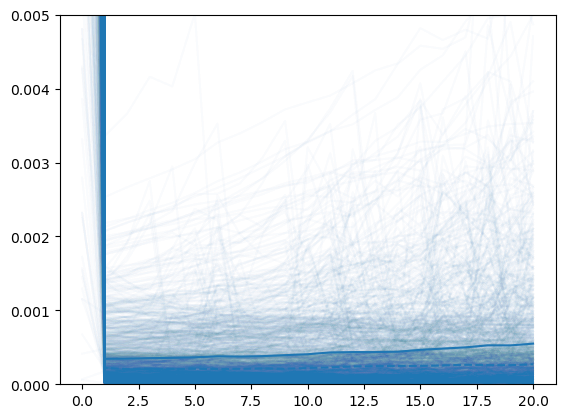

In [ ]:
# time series plot of angle penalties

a_time = np.array([[e[key] for e in angle_penalties] for key in angle_penalties[0].keys()])
plt.plot(a_time.T, color="tab:blue", alpha=.01);
plt.plot(np.mean(a_time, axis=0), color="tab:blue", alpha=1);
plt.plot(np.median(a_time, axis=0), color="tab:blue", alpha=1, ls="--");

plt.ylim([0, 5*1e-3])

(0.0, 1.0)

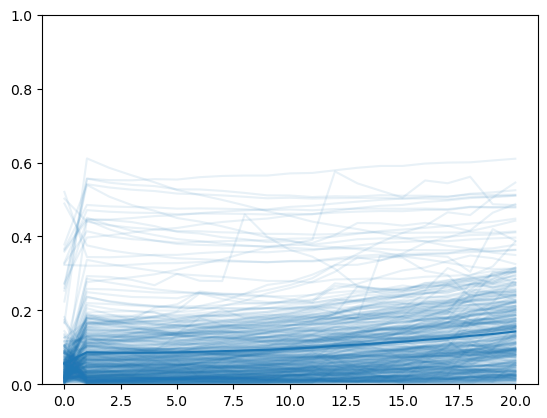

In [ ]:
# time series plot of energies

e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()])
plt.plot(e_time.T, color="tab:blue", alpha=.1);
plt.plot(e_time.mean(axis=0), color="tab:blue", alpha=1);

plt.ylim([0, 10*1e-1])

<matplotlib.collections.PathCollection>

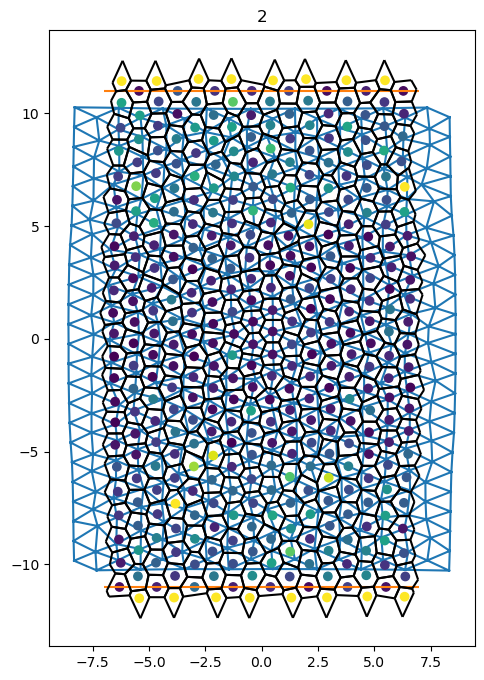

In [ ]:
# spatial plot of shape energies

i = 2

fig = plt.figure(figsize=(8,8))

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
#plt.ylim([-max_y-.5, max_y+.5])
plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
#meshes[i].labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

plt.title(i);

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([np.mean([fc.dual_coords
                                  for fc in meshes[i].vertices[key].get_face_neighbors()], axis=0), [val]])
                     for key, val in energies[i].items()], axis=-1)

plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.3)

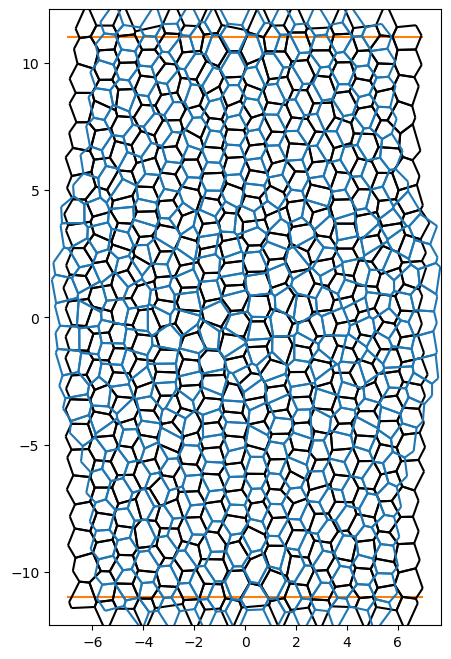

In [ ]:
fig = plt.figure(figsize=(8,8))

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
plt.gca().set_aspect("equal", adjustable="box")
meshes[1].cellplot()
meshes[-1].cellplot(edge_colors={he: "tab:blue" for he in meshes[-1].hes.keys()})


(0.0, 1.7320508075688772)

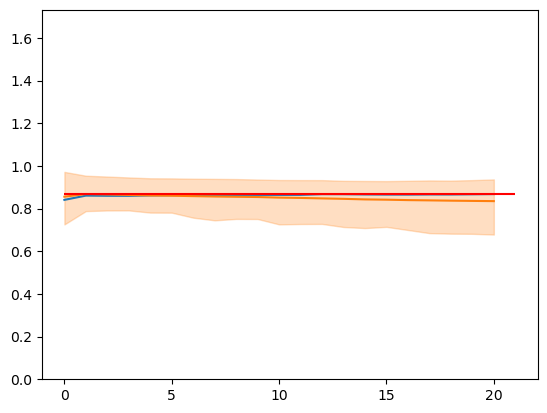

In [ ]:
# create a time-series of areas

areas = np.empty((len(meshes), len(meshes[0].vertices)))
for t, msh in enumerate(meshes):
    for v in msh.vertices.values():
        nghbs = v.get_face_neighbors()
        if (None in nghbs):
            areas[t, v._vid] = np.nan
        else: 
            areas[t, v._vid] = polygon_area(np.stack([fc.dual_coords for fc in nghbs]))
            
areas = areas[:, ~np.isnan(areas).any(axis=0)]

plt.plot(areas[:, 3])
mean = areas.mean(axis=1)

plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(sqrt(3)/2, 0, len(meshes), color="r")
plt.ylim([0, sqrt(3)])


bad behavior in passive region = actually mainly due to triangulation!

<IPython.core.display.Javascript object>


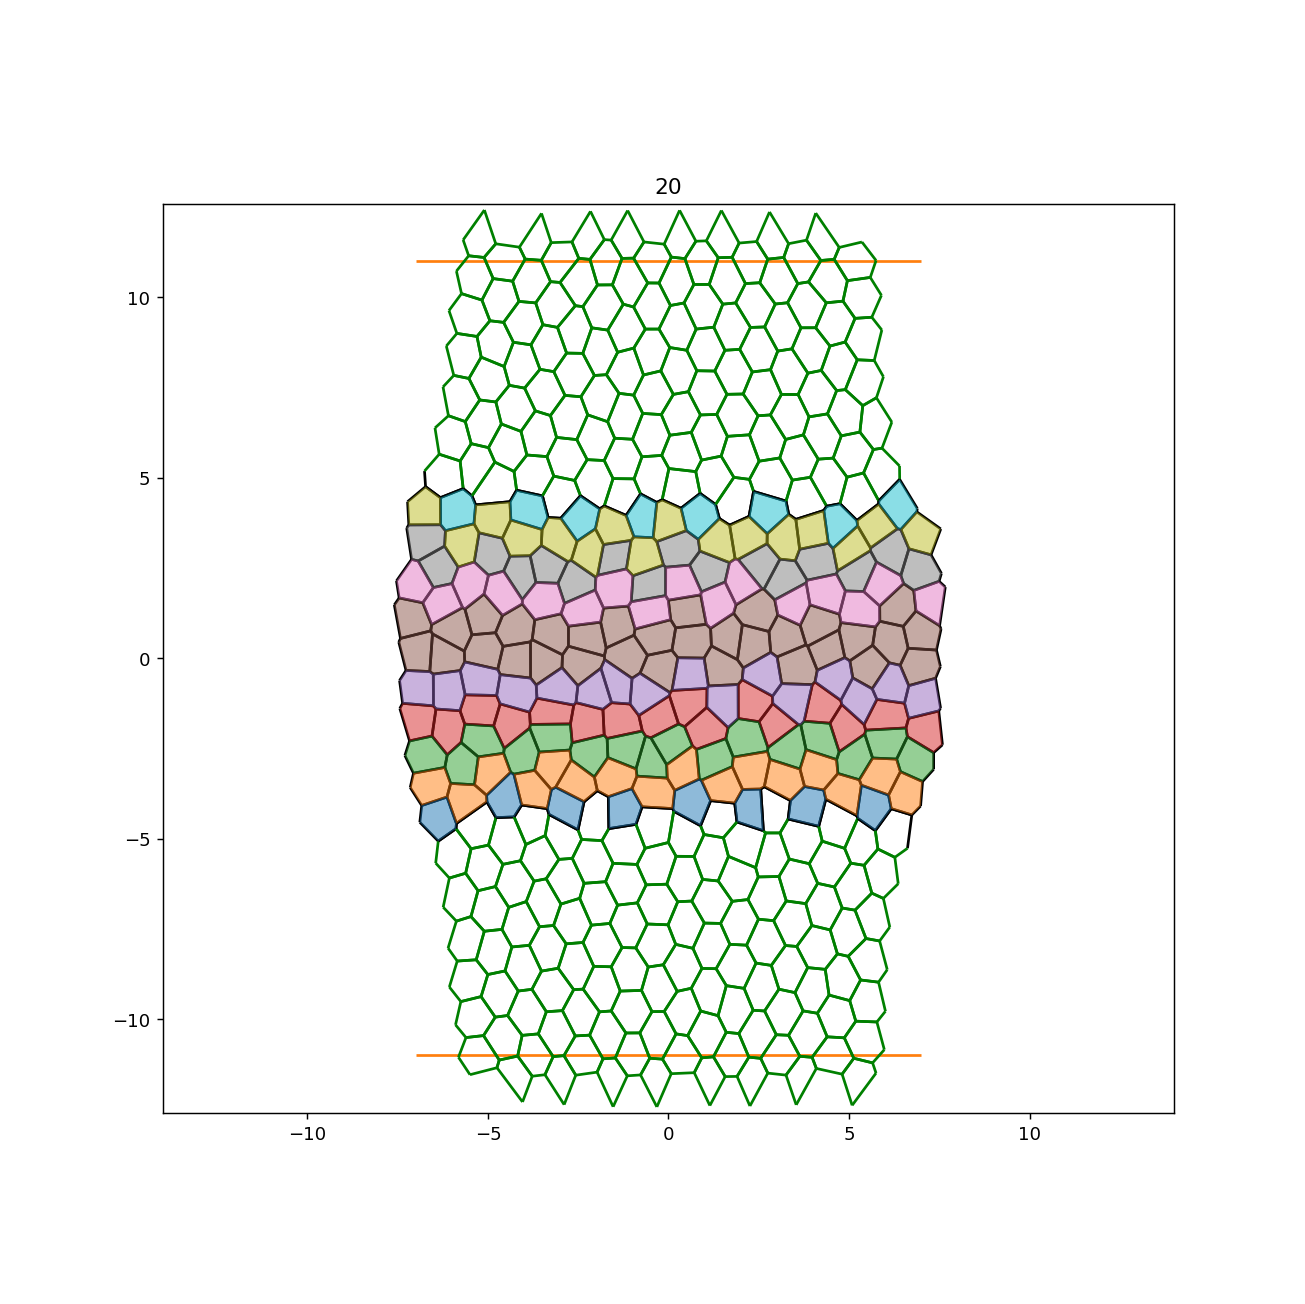

interactive(children=(IntSlider(value=10, description='i', max=20), Output()), _dom_classes=('widget-interact'…

In [ ]:
#| notest

# Slider plot

%matplotlib notebook

fig = plt.figure(figsize=(10, 10))

def plot_mesh(i):
    plt.cla()
    plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-14, 14])
    plt.ylim([-max_y-1, max_y+1])
    #plt.xlim([-2., 2])
    #plt.ylim([0, 4])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    #meshes[i].labelplot(halfedge_labels=False, vertex_labels=True, face_labels=False)
    #meshes[i].triplot()
    plt.title(i)
    for x in last_flipped_edges[i+1]:
        he = meshes[i].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        #plt.plot(*line.T, c="tab:purple", lw=4)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=4)
        
widgets.interact(plot_mesh, i=(0, len(meshes)-1, 1));

with area term in energy:

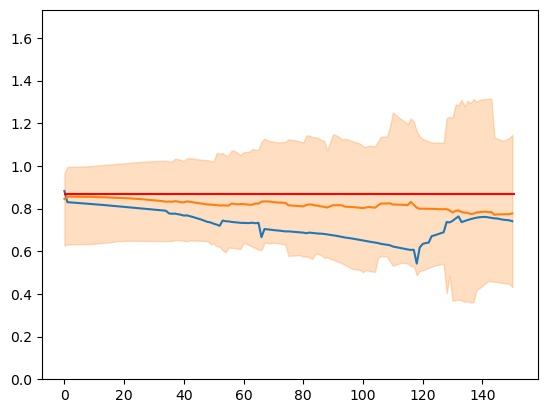

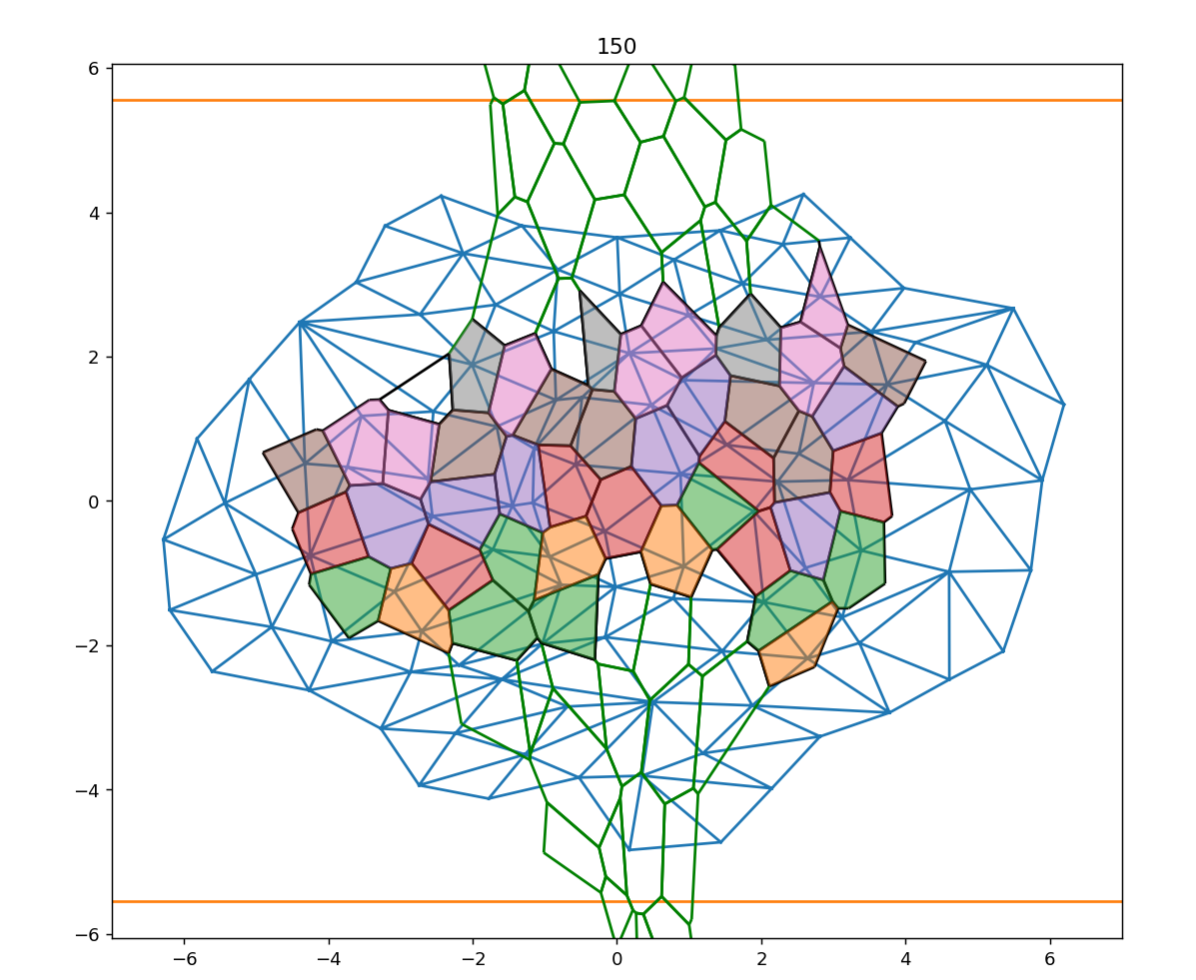

In [ ]:
#| notest
%matplotlib inline


## Plot trajectories of cell centroids, colored along trajectory by time

Say every third or so cell

### Create and save an animation

In [ ]:
#| notest
%matplotlib inline

# Save simulation as HTML5 animation

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300)
nframes, frame_dt = n_steps, 500  # Delay between frames in milliseconds

def animate_meshes(n):
    n = n+1
    plt.cla()
    plt.hlines((max_y, -max_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-7, 7])
    plt.ylim([-max_y-.5, max_y+.5])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('')
    meshes[n].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    #meshes[n].triplot()
    for x in last_flipped_edges[n+1]:
        he = meshes[n].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        #plt.plot(*line.T, c="tab:purple", lw=2)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=2)
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=nframes-1, interval=frame_dt, repeat=False)
anim.save('plots/germ_band_small_orth.mp4', fps=4,)
# maybe best to start from 1

## OLD STUFF